# Import libraries and Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# File paths
data_path = r"E:\data_analyst_internship\E-commerce_return_rate_reductions\data"
file_name = "Ecommerce_Product_Sales.csv"  # adjust if needed

# Load dataset
df = pd.read_csv(os.path.join(data_path, file_name))

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (500, 9)


,Product_ID,Product_Name,Category,Price,Units_Sold,Revenue,Rating,Return_Rate,Seller_Name
0,Product_1,Max Product_1,Toys,358.65,983,352552.95,3.63,0.16,Seller_B
1,Product_2,Pro Product_2,Home & Kitchen,248.00,79,19592.00,1.23,0.20,Seller_E
2,Product_3,Eco Product_3,Automotive,148.12,206,30512.72,2.09,0.05,Seller_D
3,Product_4,Super Product_4,Electronics,15.76,585,9219.60,3.69,0.05,Seller_D
4,Product_5,Ultra Product_5,Home & Kitchen,20.84,401,8356.84,2.01,0.15,Seller_B


# Data Cleaning

In [2]:
# Drop duplicates
df = df.drop_duplicates()

# Drop rows with missing Order_ID or User_ID (should be none)
df = df.dropna(subset=['Order_ID','User_ID'])

# Fill numeric NAs with median
num_cols = df.select_dtypes(include=['int64','float64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical NAs with mode
cat_cols = df.select_dtypes(include=['object']).columns
for c in cat_cols:
    df[c] = df[c].fillna(df[c].mode()[0])

# Target column
df['is_returned'] = df['Return_Status'].map({'Returned':1, 'Not Returned':0})

print("Cleaned dataset shape:", df.shape)
df.head()

KeyError: ['Order_ID', 'User_ID']

# Feature Engineering

In [13]:
# Convert dates
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Derived features
df['total_price'] = df['Product_Price'] * df['Order_Quantity']
df['discount_ratio'] = df['Discount_Applied'] / df['total_price']
df['order_month'] = df['Order_Date'].dt.month
df['order_dayofweek'] = df['Order_Date'].dt.dayofweek

# Handle categorical variables
for col in ['Product_Category', 'User_Location', 'Payment_Method']:
    counts = df[col].value_counts()
    rare = counts[counts < 50].index
    df[col] = df[col].replace(rare, 'Other')

# Prepare dataset for ML
df_ml = df.drop(columns=['Order_ID','Product_ID','User_ID','Return_Status','Return_Date','Return_Reason'], errors='ignore')

df_ml.head()

,Order_Date,Product_Category,Product_Price,Order_Quantity,Days_to_Return,User_Age,User_Gender,User_Location,Payment_Method,Shipping_Method,Discount_Applied,is_returned,total_price,discount_ratio,order_month,order_dayofweek
0,2023-08-05,Clothing,411.59,3,387.0,58,Male,City54,Debit Card,Next-Day,45.27,1,1234.77,0.036663,8,5
1,2023-10-09,Books,288.88,3,31.0,68,Female,City85,Credit Card,Express,47.79,1,866.64,0.055144,10,0
2,2023-05-06,Toys,390.03,5,1.0,22,Female,City30,Debit Card,Next-Day,26.64,0,1950.15,0.013660,5,5
3,2024-08-29,Toys,401.09,3,1.0,40,Male,City95,PayPal,Next-Day,15.37,0,1203.27,0.012774,8,3
4,2023-01-16,Books,110.09,4,1.0,34,Female,City80,Gift Card,Standard,16.37,0,440.36,0.037174,1,0


# Explorator Analysis

Overall Return Rate: 50.52%
Product_Category
Clothing       0.524500
Electronics    0.509320
Books          0.506614
Toys           0.495370
Home           0.490148
Name: is_returned, dtype: float64


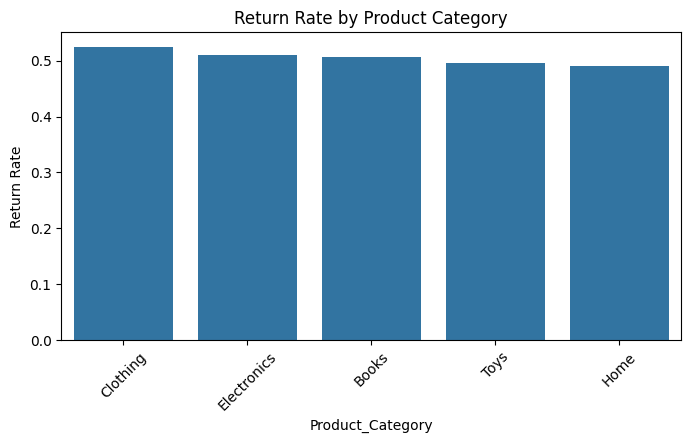

In [14]:
# Overall return rate
return_rate = df['is_returned'].mean()
print(f"Overall Return Rate: {return_rate:.2%}")

# Return % by category
category_return = df.groupby('Product_Category')['is_returned'].mean().sort_values(ascending=False)
print(category_return)

# Bar chart
plt.figure(figsize=(8,4))
sns.barplot(x=category_return.index, y=category_return.values)
plt.xticks(rotation=45)
plt.ylabel("Return Rate")
plt.title("Return Rate by Product Category")
plt.show()

# Train Logistic Regression

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Features and target
X = df_ml.drop('is_returned', axis=1)
y = df_ml['is_returned']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
num_cols = X_train.select_dtypes(include=['int64','float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Logistic Regression
model = Pipeline([
    ('prep', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Train model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.49      0.49      0.49       990
           1       0.50      0.51      0.50      1010

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000

ROC-AUC: 0.49215621562156214
